<a href="https://colab.research.google.com/github/RobBurnap/Bioinformatics-MICR4203-MICR5203/blob/main/notebooks/05_Gene_Expression/01_PCA_TimeSeries_GeneExpression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
!rm -rf /content/drive

In [55]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [21]:
!ls "/content/drive/MyDrive/Teaching/BIOINFO4-5203-F25/Data"

L02-BLASTp_diversity  L05_Gene_Expression  L05_gene_expression_PCA_clustering


# PCA of Time-Series Gene Expression

**Goal:** Reduce multi-timepoint expression profiles to 2D and color each gene by the time point where it reaches **maximum expression**.

**What students will learn**
- How to load and shape a gene × time expression matrix
- How to compute PCA on standardized features
- How to color genes by their “peak time” (earliest time with max expression)
- How to interpret PC1 / PC2 variance

In [46]:
# Core libs
import os
import numpy as np
import pandas as pd

# Viz + PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import Normalize

In [47]:
# === Edit these for your environment ===
USE_DRIVE = True  # set to False if running locally without Drive
COURSE_DIR = "/content/drive/MyDrive/Teaching/BIOINFO4-5203-F25"
DATA_DIR   = f"{COURSE_DIR}/Data/L05_Gene_Expression"
INPUT_CSV  = "CO2_downshift.csv"   # your file with 1st=geneID, 2nd–3rd=meta, rest=time points

if USE_DRIVE:
    from google.colab import drive
    drive.mount("/content/drive", force_remount=False)

data_path = os.path.join(DATA_DIR, INPUT_CSV)
print("Reading:", data_path)

df = pd.read_csv(data_path)

# Assume col0 = gene id, col1–2 = meta (drop), remaining = time columns
gene_col = df.columns[0]
meta_cols_to_drop = df.columns[1:3]  # skip 2 and 3
expr_df = df.drop(columns=meta_cols_to_drop).set_index(gene_col)

# Sanity
print("✅ Shape (genes × time):", expr_df.shape)
expr_df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Reading: /content/drive/MyDrive/Teaching/BIOINFO4-5203-F25/Data/L05_Gene_Expression/CO2_downshift.csv
✅ Shape (genes × time): (3264, 5)


,CO2 shift 1 Hour,CO2 shift 3 hour,CO2 shift tpi,CO2 shift 6 hour,CO2 shift 12 hour
UNIQID,,,,,
slr0612,<no data>,0.021,<no data>,<no data>,-0.287
slr0613,0.261,-0.024,-0.46,-0.24,-0.605
sll0558,0.064,-0.118,-0.119,-0.071,-0.04
sll1214,-0.293,-0.02,-1.186,-0.362,-0.53
sll1213,-0.063,-0.024,0.016,0.218,0.037


### Handling Missing or Non-numeric Data

Before PCA, we must ensure all features are numeric.
Here, we replaced entries like `<no data>` or `N/A` with zeros (neutral log₂ fold-change).
Alternatively, we could replace them with the mean of the time point to avoid bias.

In [50]:
# Clean and ensure all entries are numeric

# Replace textual or missing entries like "<no data>" or "NA" with NaN
expr_df = expr_df.replace(["<no data>", "NA", "N/A", ""], np.nan)

# Convert all to numeric, coercing errors to NaN
expr_df = expr_df.apply(pd.to_numeric, errors="coerce")

# Option 1: Fill NaN with 0 (neutral for log2 fold-changes)
expr_df = expr_df.fillna(0)

# Option 2 (if you prefer imputation): uncomment below instead
# expr_df = expr_df.apply(lambda col: col.fillna(col.mean()), axis=0)

print("✅ Cleaned dataframe shape:", expr_df.shape)
print("Any NaNs left?", expr_df.isna().any().any())

✅ Cleaned dataframe shape: (3264, 5)
Any NaNs left? False


## Standardize features and run PCA

- **Why standardize?** Even when all features are log2 fold-changes, centering/scaling time points helps PCA treat each time comparably.
- **Rows** are genes (observations), **Columns** are time points (features).

In [51]:
# Standardize *features* (time columns)
scaler = StandardScaler(with_mean=True, with_std=True)
X_scaled = scaler.fit_transform(expr_df.values)  # genes × time

# PCA to 2 components
pca = PCA(n_components=2, random_state=0)
scores = pca.fit_transform(X_scaled)             # genes × 2
expl_var = pca.explained_variance_ratio_ * 100   # %

# Pack into a DataFrame
pca_df = pd.DataFrame(scores, index=expr_df.index, columns=["PC1", "PC2"])
print(f"Explained variance: PC1={expl_var[0]:.1f}%, PC2={expl_var[1]:.1f}%")
pca_df.head()

Explained variance: PC1=57.2%, PC2=29.5%


,PC1,PC2
UNIQID,,
slr0612,-0.223174,0.170255
slr0613,-0.812386,1.161493
sll0558,-0.322552,-0.045153
sll1214,-1.945764,-0.423658
sll1213,0.091247,-0.358867


## Color genes by the time point of **maximum expression**

For each gene, find the time column with the **largest** value (ties resolved by the **earliest** time). We’ll color the PCA scatter by this categorical “peak time.”

In [53]:
time_labels = expr_df.columns.tolist()

# index of max for each row (gene)
peak_idx = np.nanargmax(expr_df.values, axis=1)
pca_df["PeakTimeNum"] = peak_idx
pca_df["PeakTimeLabel"] = [time_labels[i] for i in peak_idx]

# quick check
pca_df["PeakTimeLabel"].value_counts().sort_index()

,count
PeakTimeLabel,
CO2 shift 1 Hour,933
CO2 shift 12 hour,774
CO2 shift 3 hour,526
CO2 shift 6 hour,398
CO2 shift tpi,633


## PCA Scatter Colored by Peak Time

- Each point = gene  
- Color = the time point at which that gene reaches its maximum expression

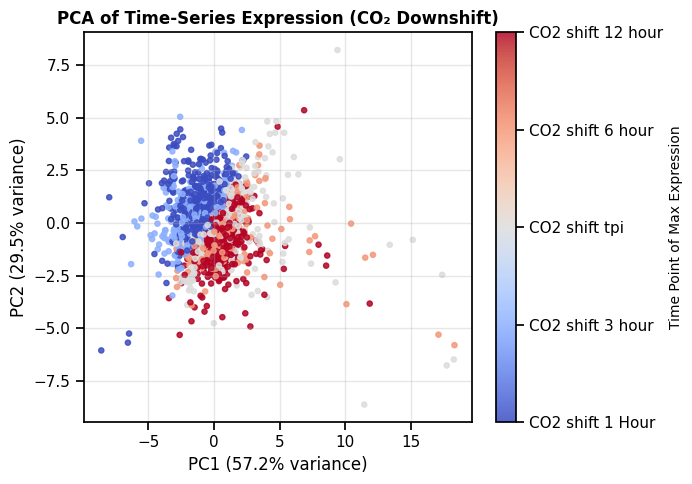

In [54]:
sns.set_context("notebook")
palette = sns.color_palette("coolwarm", len(time_labels))
norm = Normalize(vmin=0, vmax=len(time_labels)-1)

fig, ax = plt.subplots(figsize=(7, 5))
sc = ax.scatter(
    pca_df["PC1"], pca_df["PC2"],
    c=pca_df["PeakTimeNum"],
    cmap="coolwarm", s=14, alpha=0.85)

# Colorbar with time labels
cbar = fig.colorbar(sc, ax=ax)
cbar.set_ticks(range(len(time_labels)))
cbar.set_ticklabels(time_labels)
cbar.set_label("Time Point of Max Expression", fontsize=10)

ax.set_title("PCA of Time-Series Expression (CO₂ Downshift)", weight="bold")
ax.set_xlabel(f"PC1 ({expl_var[0]:.1f}% variance)")
ax.set_ylabel(f"PC2 ({expl_var[1]:.1f}% variance)")
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Student Experiments (“Try this”)

- Change `INPUT_CSV` to try another time-series dataset.
- Filter to **top N most variable genes** before PCA:
  ```python
  N = 1000
  var = expr_df.var(axis=1)
  top = var.nlargest(N).index
  expr_df_sub = expr_df.loc[top]